# 7 Test Model

## 7.1 Install and loaf libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 145 kB 52.4 MB/s 
     |████████████████████████████████| 181 kB 39.9 MB/s 
     |████████████████████████████████| 63 kB 933 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=21cddd1302addbdba7886fd0bc251a9f9bcaf70bfd6191e8624dedab8553fc4d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
# Login to Weights & Biases
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 7.2 Test Evaluation

### 7.2.1 Base classes definition

This is necessary in order to joblib.load() see the previous definitions used in the Train Pipeline

In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self. Nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method taht describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical Features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self. Nothing to do here
    def fit(self, X, y=None):
        return self

    def get_features_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        # df = df.apply(lambda row: row.str.strip())

        # Customize features - Defined by EDA

        if self.new_features:
            # drop the url feature
            cols_to_remove = ['url']

            df.drop(labels=cols_to_remove,axis=1,inplace=True)

        return df

# Transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: no scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statiscal about scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        #update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            df = self.scaler.transform(df)
        elif self.model == 1:
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

### 7.2.2 Evaluation

In [6]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "phishing-detection/test.csv:latest"

# name of the model artifact
artifact_model_name = "phishing-detection/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name = "phishing-detection/target_encoder:latest"

In [7]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S")

# reference for a logging obj
logger = logging.getLogger()

In [8]:
# initiate the wandb project
run = wandb.init(project="phishing-detection",job_type="test")

wandb: Currently logged in as: lupamedeiros. Use `wandb login --relogin` to force relogin


In [9]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("status")

2022-05-28 14:02:07 Downloading and reading test artifact
2022-05-28 14:02:08 Extracting target from dataframe


In [10]:
# Takes a look at test set
x_test.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,http://email.zalinco.com,24,17,0,2,0,0,0,0,0,...,0,1,1,0,278,3374,0,0,1,1
1,https://www.codeproject.com/articles/614028/We...,56,19,0,2,0,0,0,0,0,...,0,0,0,0,841,7559,1695,0,1,7
2,http://prassel.nu/wordpress/wp-content/themes/...,69,10,0,2,1,0,0,0,0,...,0,1,1,0,313,783,0,0,1,1
3,http://www.optus.com.au/shop/broadband/mobile-...,55,16,0,3,1,0,0,0,0,...,0,0,0,1,0,-1,9075,0,0,6
4,https://en.wikipedia.org/wiki/Bridge_convention,47,16,0,2,0,0,0,0,0,...,0,0,1,0,903,7132,12,0,0,7


In [11]:
# Take a look at the target variable
y_test.head()

0      phishing
1    legitimate
2      phishing
3    legitimate
4    legitimate
Name: status, dtype: object

In [12]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

2022-05-28 14:02:55 Extracting the encoding of the target variable


In [13]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

2022-05-28 14:03:09 Classes [0, 1]: ['legitimate' 'phishing']


In [14]:
# target variable after the encoding
y_test

array([1, 0, 1, ..., 1, 0, 1])

In [15]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

2022-05-28 14:03:30 Downloading and load the exported model


In [16]:
# predict
logger.info("Infering")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

2022-05-28 14:03:46 Infering
2022-05-28 14:03:46 Test Evaluation metrics
2022-05-28 14:03:46 Test Accuracy: 0.9225721784776902
2022-05-28 14:03:46 Test Precision: 0.9214659685863874
2022-05-28 14:03:46 Test Recall: 0.9238845144356955
2022-05-28 14:03:46 Test F1: 0.9226736566186107


In [17]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1143
           1       0.92      0.92      0.92      1143

    accuracy                           0.92      2286
   macro avg       0.92      0.92      0.92      2286
weighted avg       0.92      0.92      0.92      2286



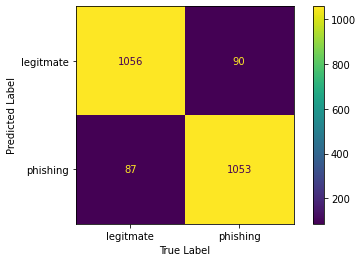

In [18]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=["legitmate","phishing"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [19]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

2022-05-28 14:05:10 Uploading figures


In [20]:
run.finish()

Acc,0.92257
F1,0.92267
Precision,0.92147
Recall,0.92388
